/**********************************************************************************
 * Copyright (c) 2023 Process Systems Engineering (AVT.SVT), RWTH Aachen University
 *
 * This program and the accompanying materials are made available under the
 * terms of the Eclipse Public License 2.0 which is available at
 * http://www.eclipse.org/legal/epl-2.0.
 *
 * SPDX-License-Identifier: EPL-2.0
 *
 * The source code can be found here:
 * https://github.com/iAMB-RWTH-Aachen/Ustilago_maydis-GEM/tree/master/data/AcetateCofeed
 **********************************************************************************/


Date: 14.12.2023 <br/>
File name: Itaconic acid yield over glucose and acetate flux 10 percent biomass.ipynb <br/>
Description: Itaconic acid yield at 10 percent biomass flux.
The COBRApy package (https://doi.org/10.1186/1752-0509-7-74  ) is used to together with the solver Gurobi 9.5.2 to solve the 
linear programming problems. <br/>
@authors: Manuel Boßmann, Anita Ziegler, Ulf Liebal, Alexander Mitsos


In [1]:
from os.path import join
from cobra.io import read_sbml_model
import numpy as np


# loading matplotlib, a library for visualization
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# loading colormap for matplotlib
from cmcrameri import cm

In [2]:
#load iUma22v1.1.xml model
ModelFile = join('..', '..', '..','model','iUma22v1.1.xml')
model=read_sbml_model(ModelFile)

Give concentrations to be evaluated

In [3]:
#Glucose uptake concentration in g/L in accordance with experimental data. See table 2.
#Stopping at 80 g/L since this is the maximum allowable range from concentration-flux-correlation.
list_glc_uptake = list(range(26,81))

In [4]:
#Acetate uptake concentration in g/L in accordance with experimental data. See table 2.
#Stopping at 11.5 g/L since this is the maximum allowable range from concentration-flux-correlation.
list_ace_uptake = [1.5,1.75,2,2.25,2.5,2.75,3,3.25,3.5,3.75,4,4.25,4.5,4.75,5,5.25,5.5,5.75,6,6.25,6.5,6.75,7,7.25,7.5,7.75,8,8.25,8.5,8.75,9,9.25,9.5,9.75,10,10.25,10.5,10.75,11,11.25,11.5]

Define functions to convert concentration to flux

In [5]:
def to_glc_flux(glc,ace):
    """Takes glucose and acetate conentrations and return glucose flux."""
    return round(0.96818+glc*0.00316+ace*-0.09218+glc*ace*0.000243123,5)

def to_ace_flux(glc,ace):
    """Takes glucose and acetate concentration and return acetate flux."""
    return round(0.30096+glc*-0.0025+ace*0.0687+glc*ace*-0.00106,5)

In [6]:
list_growth_rate = []
list_ita_flux = []
list_glc_flux = []
list_ace_flux = []
list_glc_conc = []
list_ace_conc = []

In [7]:
#Simulate itaconic acid flux with different acetate and glucose fluxes




for x in range(0,len(list_glc_uptake)):
    for y in range(0,len(list_ace_uptake)):
        #Set input flux via medium.
        medium = model.medium
        medium['EX_glc__D_e']=to_glc_flux(list_glc_uptake[x], list_ace_uptake[y])
        medium['EX_ac_e']=to_ace_flux(list_glc_uptake[x], list_ace_uptake[y])
        model.medium = medium
        model.objective = "BIOMASS_REACTION"
        solution = model.optimize()

        #For some uptake flux inputs the optimization problem is not solvable. This behavior is expected.
        #The unsolvability is e.g. due to a negative itaconic acid yield, which is not allowed.
        #The infeasible results are omitted.   

        #A two step optimization is carried out. First, biomass is the model objective.
        #Then, 0.5 of the obtained biomass flux is set as a lower bound.
        #Lastly, itaconic acid is the model objective.
        if solution.status != "infeasible":
            biomass = solution.objective_value
            model.reactions.BIOMASS_REACTION.lower_bound = 0.1*biomass
            model.objective = "EX_itacon_e"
            solution = model.optimize()
            if solution.status != "infeasible":
                #A input flux set via the medium (see above) may be lower than the flux used by the model after optimization. We call this "model flux".
                #This is, because the input flux set by the medium is a range from 0 to the given input flux.
                #To ensure comparability with experimental results, only the results where the "model flux" equals the input flux are used.
                delta_ace = medium['EX_ac_e'] +model.reactions.EX_ac_e.flux
                delta_glc = medium['EX_glc__D_e'] + model.reactions.EX_glc__D_e.flux
                if abs(delta_ace) < 1e-5 and abs(delta_glc) < 1e-5:   
                    list_ita_flux.append(round(model.reactions.EX_itacon_e.flux,5))
                    list_glc_flux.append(round(-model.reactions.EX_glc__D_e.flux,5))
                    list_ace_flux.append(round(-model.reactions.EX_ac_e.flux,5))         
                    list_glc_conc.append(list_glc_uptake[x])
                    list_ace_conc.append(list_ace_uptake[y])
            
            

c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\Manuel\AppData\Local\Programs\Python\Python312\Lib\site-packages\cobra\util\solver.py:554: UserWarning: Solver status is 'infeasible'.
  warn(f"Solver status is '{status}'.", UserWarning)
c:\Users\Manuel

In [8]:
#calculate itaconic acid yield
def to_ita_yield(ita,glc,ace):
    """Takes itaonic acid, glucose and acetate flux and return itaconic acid yield."""
    return round(5*ita/(6*glc+2*ace),3)

list_ita_yield = []
for x in range(0,len(list_ita_flux)):
    list_ita_yield.append(to_ita_yield(list_ita_flux[x], list_glc_flux[x], list_ace_flux[x]))

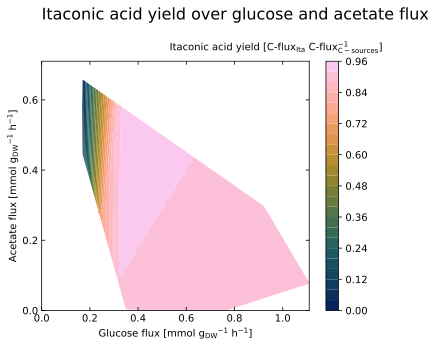

In [11]:
#create graph
cmap = cm.batlow


fig, ax =plt.subplots(figsize = (6,4.5))
ax.set_xlim([0, 1.11])
ax.set_ylim([0, 0.71])
ax.set_title("Itaconic acid yield over glucose and acetate flux\n\n", loc = "left", fontsize = 16)
ax.set_xlabel(r"Glucose flux [mmol g$_{\mathrm{DW}}$$^{-1}$ h$^{-1}$]")
ax.set_ylabel(r"Acetate flux [mmol g$_{\mathrm{DW}}$$^{-1}$ h$^{-1}$]")
ax.tick_params(direction = "in", top = True, right = True)
ax.set_yticks([0, 0.2, 0.4, 0.6])


# plot_growth_rate = ax.tricontourf(list_glc_flux, list_ace_flux, list_ita_yield, np.linspace(0.0, 0.7, 50), cmap = cmap)
# contour = ax.tricontour(list_glc_flux, list_ace_flux, list_ita_yield, np.linspace(0.0, 0.7, 50), colors="w", linewidths=0.1)
plot_growth_rate = ax.tricontourf(list_glc_flux, list_ace_flux, list_ita_yield, cmap = cmap, levels=26)
#contour = ax.tricontour(list_glc_flux, list_ace_flux, list_ita_yield, colors="w", linewidths=0.1)


#ax.clabel(contour, colors="w")

colorbar = plt.colorbar(plot_growth_rate, cmap = cmap, format = "%.2f")
colorbar.ax.set_ylabel(r'Itaconic acid yield [C-flux$_{\mathrm{Ita}}$ C-flux$_{\mathrm{C-sources}}^{-1}$]', fontsize = 10, rotation = 0)
colorbar.ax.yaxis.set_label_coords(-4,1.08)

plt.show()